# Football Match Outcome Prediction - Project

In [6]:
import pandas as pd
import pickle
import numpy as np

To begin, I am just going to work with one dataset. I am using the 2019/20 Premier League season for initial cleaning and feature engineering and then extrapolating with other leagues. 

Any unique errors that come up with certain leagues and years will be dealt with accordingly using this approach.

In [73]:
year = 2020
pl_results = pd.read_csv(f"Football-Dataset/premier_league/Results_{year}_premier_league.csv")
pl_results_initial = pd.read_csv(f"Football-Dataset/premier_league/Results_{year}_premier_league.csv")

pl_results.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Liverpool,Norwich City,4-1,https://www.besoccer.com/match/liverpool/norwi...,2020,1,premier_league
1,West Ham,Man. City,0-5,https://www.besoccer.com/match/west-ham-united...,2020,1,premier_league
2,AFC Bournemouth,Sheffield United,1-1,https://www.besoccer.com/match/afc-bournemouth...,2020,1,premier_league
3,Burnley,Southampton,3-0,https://www.besoccer.com/match/burnley-fc/sout...,2020,1,premier_league
4,Crystal Palace,Everton,0-0,https://www.besoccer.com/match/crystal-palace-...,2020,1,premier_league


### Merge match_info with pl_results

In [78]:
match_info = pd.read_csv("datasets/Match_Info.csv")

match_info.head()

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hans-Jürgen Weber\r\n,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Kurt Wittke\r\n,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Werner Föckler\r\n,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Heinz Werner\r\n,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hans-Peter Dellwing\r\n,1.0,0.0,1.0,0.0


pl_results and match_info can be merged using the Link column. However, they bother differ slightly:

- The Link column in pl_results table strangely has four extra characters at the end of each Link string which is missing on the match_info Links. This has to be trimmed off for merging with match info dataframe later on 

- Also the Link column in the match_info table is missing the beginning of the besoccer hyperlink found in pl_results table.

In [79]:
pl_results["Link"] = pl_results["Link"].str.slice(0, -4) # removes trailing 4 characters in each Link
match_info["Link"] = 'https://www.besoccer.com' + match_info["Link"]


match_info["Referee"] = match_info["Referee"].str.replace('Referee: ', '').str.replace('\r\n', '') # Referee column on match_info has unwanted characters 

match_info

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,https://www.besoccer.com/match/saarbrucken/stu...,"Saturday, 29 July 1989, 15:00",Hans-Jürgen Weber,0.0,0.0,3.0,0.0
1,https://www.besoccer.com/match/sc-freiburg/unt...,"Saturday, 29 July 1989, 15:00",Kurt Wittke,1.0,0.0,0.0,0.0
2,https://www.besoccer.com/match/vfl-osnabruck/m...,"Saturday, 29 July 1989, 15:00",Werner Föckler,3.0,0.0,2.0,0.0
3,https://www.besoccer.com/match/rot-weiss-essen...,"Saturday, 29 July 1989, 15:00",Heinz Werner,2.0,0.0,2.0,0.0
4,https://www.besoccer.com/match/alemannia-aache...,"Saturday, 29 July 1989, 15:00",Hans-Peter Dellwing,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
143343,https://www.besoccer.com/match/sunderland-afc/...,"Saturday, 19 September 1998, 00:00",Anthony Leake,1.0,0.0,0.0,0.0
143344,https://www.besoccer.com/match/fc-gueugnon/bas...,"Tuesday, 17 May 1994, 00:00",Jacques Poulain,0.0,0.0,0.0,0.0
143345,https://www.besoccer.com/match/tranmere-rovers...,"Friday, 08 January 1999, 00:00",Kevin Lynch,2.0,0.0,1.0,0.0
143346,https://www.besoccer.com/match/sochaux/guingam...,"Saturday, 27 February 2021, 19:00",Baert A.,0.0,0.0,2.0,0.0


In [80]:
# Merge datasets
pl_results = pd.merge(pl_results, match_info, on='Link')

pl_results.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League,Number_teams,Total_rounds,Home_Goals,...,Total_Goals_For_Home_Team,Total_Goals_Against_Home_Team,Total_Goals_For_Away_Team,Total_Goals_Against_Away_Team,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,Liverpool,Norwich City,4-1,https://www.besoccer.com/match/liverpool/norwi...,2020,1,premier_league,20,38,4,...,0.0,0.0,0.0,0.0,"Friday, 09 August 2019, 21:00",Oliver M.,0.0,0.0,2.0,0.0
1,West Ham,Man. City,0-5,https://www.besoccer.com/match/west-ham-united...,2020,1,premier_league,20,38,0,...,0.0,0.0,0.0,0.0,"Saturday, 10 August 2019, 13:30",Dean M.,2.0,0.0,2.0,0.0
2,AFC Bournemouth,Sheffield United,1-1,https://www.besoccer.com/match/afc-bournemouth...,2020,1,premier_league,20,38,1,...,0.0,0.0,0.0,0.0,"Saturday, 10 August 2019, 16:00",Friend K.,2.0,0.0,1.0,0.0
3,Burnley,Southampton,3-0,https://www.besoccer.com/match/burnley-fc/sout...,2020,1,premier_league,20,38,3,...,0.0,0.0,0.0,0.0,"Saturday, 10 August 2019, 16:00",Scott G.,0.0,0.0,0.0,0.0
4,Crystal Palace,Everton,0-0,https://www.besoccer.com/match/crystal-palace-...,2020,1,premier_league,20,38,0,...,0.0,0.0,0.0,0.0,"Saturday, 10 August 2019, 16:00",Moss J.,2.0,0.0,3.0,1.0


In [19]:
# Test if merged correctly. Length of initial dataset and merged dataset should be the same

print(len(pl_results_initial), len(pl_results))

380 380


### Merge team_info with pl_results

In [37]:
team_info = pd.read_csv("datasets/Team_Info.csv")

team_info

,Team,City,Country,Stadium,Capacity,Pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,Natural
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,Natural
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,Natural
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,Natural
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,Natural
...,...,...,...,...,...,...
539,Latina,Latina,Italy,Stadio Comunale Domenico Francioni,8000,Natural
540,Virtus Entella,Chiavari,Italy,Stadio Comunale Chiavari,4154,Césped Artificial
541,Nuova Cosenza,Cosenza,Italy,Stadio San Vito,24209,Natural
542,Pordenone,Pordenone,Italy,NaN,3089,NaN


In [35]:
team_info.isnull().sum().sort_values(ascending=False)

Stadium     97
Pitch       97
Team         0
City         0
Country      0
Capacity     0
dtype: int64

In [81]:
# Merge datasets

pl_results = pd.merge(pl_results, team_info, how='left', left_on='Home_Team', right_on='Team').drop('Team', axis='columns')

pl_results.head()


,Home_Team,Away_Team,Result,Link,Season,Round,League,Number_teams,Total_rounds,Home_Goals,...,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,City,Country,Stadium,Capacity,Pitch
0,Liverpool,Norwich City,4-1,https://www.besoccer.com/match/liverpool/norwi...,2020,1,premier_league,20,38,4,...,Oliver M.,0.0,0.0,2.0,0.0,Liverpool,England,Anfield,54074,Natural
1,West Ham,Man. City,0-5,https://www.besoccer.com/match/west-ham-united...,2020,1,premier_league,20,38,0,...,Dean M.,2.0,0.0,2.0,0.0,Londres,England,London Stadium,80000,Natural
2,AFC Bournemouth,Sheffield United,1-1,https://www.besoccer.com/match/afc-bournemouth...,2020,1,premier_league,20,38,1,...,Friend K.,2.0,0.0,1.0,0.0,Bournemouth,England,Vitality Stadium,12000,Natural
3,Burnley,Southampton,3-0,https://www.besoccer.com/match/burnley-fc/sout...,2020,1,premier_league,20,38,3,...,Scott G.,0.0,0.0,0.0,0.0,Burnley,England,Turf Moor,22546,Natural
4,Crystal Palace,Everton,0-0,https://www.besoccer.com/match/crystal-palace-...,2020,1,premier_league,20,38,0,...,Moss J.,2.0,0.0,3.0,1.0,Londres,England,Selhurst Park,26309,Natural


In [36]:
# Test if merged correctly. Length of initial dataset and merged dataset should be the same

print(len(pl_results_initial), len(pl_results))

380 380


### Check for missing values

In [152]:
# column by column check for missing values
pl_results.isnull().sum().sort_values(ascending=False) 

Pitch                            19
Capacity                         19
Stadium                          19
Country                          19
City                             19
Total_Goals_Against_Home_Team     0
Wins_When_Away                    0
Draws_When_Away                   0
Losses_When_Away                  0
Points_Home                       0
Points_Away                       0
Position_Home                     0
Position_Away                     0
Total_Goals_For_Home_Team         0
Total_Goals_Against_Away_Team     0
Total_Goals_For_Away_Team         0
Draws_When_Home                   0
Date_New                          0
Referee                           0
Home_Yellow                       0
Home_Red                          0
Away_Yellow                       0
Away_Red                          0
Losses_When_Home                  0
Home_Team                         0
Away_Team                         0
Total_Loss_Away_Team              0
Result                      

In [153]:
# get total number of missing values
pl_results.isnull().sum().sum()

# All null values correspond to Brighton Hove Albion home games

95

## Feature Engineering

Create new features for dataset that may return interesting insights

In [48]:
# Extract ELO of each team
elo_list_raw = pickle.load(open('datasets/elo_dict.pkl', 'rb'))

In [49]:
# Convert elo_list_raw dictionary into pandas dataframe (transposed)
elo_list = pd.DataFrame.from_dict(pickle.load(open('datasets/elo_dict.pkl', 'rb'))).T.reset_index()

In [4]:
# Add features to dataframe

def add_elo(results_table, elo_list):
    '''
    Adds Elo_home and Elo_away columns to dataframe for each match for given results_table.

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round and League.

    Returns
    -------
    results_table_elo: pandas.core.frame.DataFrame
        Merges input results_table dataframe with global dataframe elo_list, which contains 
        values for Elo_home and Elo_away for each match. Uses equivalent values in Link
        and index columns to merge dataframes.
    '''
    results_table_elo = pd.merge(results_table, elo_list, left_on="Link", right_on="index").drop("index", axis=1) # .drop index column as duplicate values with link column
    return results_table_elo

def home_away_goals(results_table):
    '''
    Adds Home_Goals and Away_Goals columns to dataframe. Uses the Results column and inputs 
    values for number of home goals and away goals for each match for given results_table. 

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Input results_table with additional columns stating the number of Home and Away goals.
    '''

    home_result = []
    away_result = []

    # iterate through each value in Result column and splits into home and away goals
    for results in results_table["Result"]:
        home_result.append(int(results[:results.find('-')]))
        away_result.append(int(results[results.find('-')+1:]))

    # create new columns Home_Goals and Away_Goals
    results_table["Home_Goals"] = home_result
    results_table["Away_Goals"] = away_result
    
    return results_table

def win_loss_draw(results_table):
    '''
    Adds Label column to results_table which dictates if match result was Home Win, Away Win
    or a Draw.

    *IMPORTANT* Requires Home_Goals and Away_Goals columns in input results_table which can be 
    generated using the home_away_goals function. (This function will automatically run the home_away_goals 
    function on input results_table if Home_Goals and Away_Goals columns not found).
    Args

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Input results_table with additional columns stating the number of Home and Away goals.
    '''

    # if Home_Goals and Away_Goals columns are not in the results_table, generate them here
    if "Home_Goals" and "Away_Goals" not in results_table:
        home_away_goals(results_table)

    #define conditions for win or loss
    conditions = [results_table["Home_Goals"] > results_table["Away_Goals"], 
                results_table["Home_Goals"] < results_table["Away_Goals"]]

    # define choices : 1-Home Win, -1-Away Win, 0-Draw
    choices = [1, -1]

    #create new column in DataFrame that displays results of comparisons
    results_table["Label"] = np.select(conditions, choices, default=0)

    return results_table

def number_of_teams(results_table):
    '''
    Adds Number_Teams feature to results_table. This feature outputs the number of teams
    playing for the given league by counting the number of unique values in the Home_Team column.

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Append to input results_table with additional column Number_Teams; number of unique teams in
        results_table.
    '''
    results_table["Number_teams"] = len(pl_results["Home_Team"].unique())
    return results_table

def total_rounds(results_table):
    '''
    Adds Total_Rounds feature to results_table. This feature outputs the total number of match 
    rounds in given league using the Round column.

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Append to input results_table with additional column Total_rounds; max number of rounds in
        results_table.
    '''
    results_table["Total_rounds"] = max(pl_results["Round"])
    return results_table

def points_position(results_table):
    '''
    Adds four new features to results_table relating to points and position including:
        - Points_Home: Current number of match points for the Home Team 
        - Points_Away: Current number of match points for the Away Team 
        - Position_Home: Current league position of the Home Team 
        - Position_Away: Current league position of the Away Team 

    *IMPORTANT* Requires Home_Goals and Away_Goals columns in input results_table which can be 
    generated using the home_away_goals function. (This function will automatically run the home_away_goals 
    function on input results_table if Home_Goals and Away_Goals columns not found).

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Append to input results_table with additional columns Points_Home, Points_Away, 
        Position_Home, Position_Away.
    '''
    # if Home_Goals and Away_Goals columns are not in the results_table, generate them here
    if "Home_Goals" and "Away_Goals" not in results_table:
        home_away_goals(results_table)

    # map each team in given league with number of points and position. This will track their points and position throughout each game played
    team_points = {team : 0 for team in results_table["Home_Team"].unique()}
    position = {team : 0 for team in results_table["Home_Team"].unique()}

    # initialise dataframe which will state the number of points the Home and Away team has before going into a game, and respective position
    points_final = pd.DataFrame(
        {"Points_Home" : [],
        "Points_Away" : [],
        "Position_Home" : [],
        "Position_Away" : []
        }
    )

    # loop through each record in the results_table
    for index, row in results_table.iterrows():
        
        # order teams from highest to lowest points -- this will help determine their current position 
        points_ordered = {k: v for k, v in sorted(team_points.items(), key=lambda item: item[1], reverse=True)}
 
        # new dataframe which contains number of points and positions for the Home and Away team for given game 
        current_points = pd.DataFrame(
                {"Points_Home" : [team_points[row['Home_Team']]],
                "Points_Away" : [team_points[row['Away_Team']]],
                "Position_Home" : [position[row['Home_Team']]],
                "Position_Away" : [position[row['Away_Team']]]
                }
            )

        # Win +3, Loss +0, Draw +1
        if row['Home_Goals'] > row['Away_Goals']:
            team_points[row['Home_Team']] += 3

        elif row['Home_Goals'] == row['Away_Goals']:
            team_points[row['Home_Team']] += 1
            team_points[row['Away_Team']] += 1

        else:
            team_points[row['Away_Team']] += 3

        # find position of team based on number of points
        ### TO DO : ADD IN CONDITIONAL -- IF POINTS ARE THE SAME DETERMINE POSITION BASED ON GOAL DIFFERENCE ###
        if row["Round"] > 1:
            for index, team in enumerate(points_ordered):
                position[team] = index+1


        # Append new points values to end of dataframe
        # reset_index(drop=True) helps avoid InvalidIndexError
        points_final = pd.concat([points_final, current_points]).reset_index(drop=True)

    # Append Points_Home, Points_Away, Position_Home and Position_Away columns to results_table for each record
    results_table = pd.concat([results_table, points_final], axis=1)

    return results_table

def total_goals(results_table):
    '''
    Adds four new features to results_table relating to goals including:
        - Total_Goals_For_Home_Team: Total number of goals scored by Home Team (up to given game)
        - Total_Goals_Against_Home_Team: Total number of goals scored against Home Team (up to given game)
        - Total_Goals_For_Away_Team: Total number of goals scored by Away Team (up to given game)
        - Total_Goals_Against_Away_Team: Total number of goals scored against Away Team (up to given game)

    *IMPORTANT* Requires Home_Goals and Away_Goals columns in input results_table which can be 
    generated using the home_away_goals function. (This function will automatically run the home_away_goals 
    function on input results_table if Home_Goals and Away_Goals columns not found).

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Append to input results_table with additional columns Total_Goals_For_Home_Team, Total_Goals_Against_Home_Team, 
        Total_Goals_For_Away_Team, Total_Goals_Against_Away_Team.
    '''

    # if Home_Goals and Away_Goals columns are not in the results_table, generate them here
    if "Home_Goals" and "Away_Goals" not in results_table:
        home_away_goals(results_table)

    # dictionary which stores the total goals scored by each team and total goals scored against each team 
    goals_for = {team : 0 for team in results_table["Home_Team"].unique()}
    goals_against = {team : 0 for team in results_table["Home_Team"].unique()}

    # initialise dataframe which will state the number of goals the Home and Away team have scored/conceded before going into a game
    goals_final = pd.DataFrame(
        {"Total_Goals_For_Home_Team" : [],
        "Total_Goals_Against_Home_Team"  : [],
        "Total_Goals_For_Away_Team" : [],
        "Total_Goals_Against_Away_Team" : []
        }
    )

     # loop through each record in the results_table
    for index, row in results_table.iterrows():

        # new dataframe which contains number of goals for the Home and Away team for particular game 
        current_goals = pd.DataFrame(
                {"Total_Goals_For_Home_Team" : [goals_for[row['Home_Team']]],
                "Total_Goals_Against_Home_Team"  : [goals_against[row['Home_Team']]],
                "Total_Goals_For_Away_Team" : [goals_for[row['Away_Team']]],
                "Total_Goals_Against_Away_Team" : [goals_against[row['Away_Team']]]
                }
            )

        # add number of goals scored in game to the total number of goals scored for each team
        goals_for[row['Home_Team']] += row['Home_Goals']
        goals_for[row['Away_Team']] += row['Away_Goals']

        # add number of goals conceded in game to the total number of goals conceded for each team
        goals_against[row['Home_Team']] += row['Away_Goals']
        goals_against[row['Away_Team']] += row['Home_Goals']


        # Append new goals values to end of dataframe
        # reset_index(drop=True) helps avoid InvalidIndexError
        goals_final = pd.concat([goals_final, current_goals]).reset_index(drop=True)

    # Append Total_Goals_For_Home_Team, Total_Goals_For_Away_Team, Total_Goals_Against_Home_Team and Total_Goals_Against_Away_Team to results_table for each record
    results_table = pd.concat([results_table, goals_final], axis=1)

    return results_table

def total_result(results_table):
    '''
    Adds eight new features to results_table relating to a teams numbers of wins, draws and losses including:
        - Total_Wins_Home_Team: Total number of wins for Home Team
        - Total_Draws_Home_Team: Total number of draws for Home Team
        - Total_Loss_Home_Team: Total number of losses for Home Team
        - Total_Wins_Away_Team: Total number of wins for Away Team
        - Total_Draws_Away_Team: Total number of draws for Away Team
        - Total_Loss_Away_Team: Total number of losses for Away Team
        - Wins_When_Home: Total number of Home wins for Home Team
        - Draws_When_Home: Total number of Home draws for Home Team
        - Losses_When_Home: Total number of Home losses for Home Team
        - Wins_When_Away: Total number of Away wins for Away Team
        - Draws_When_Away: Total number of Away draws for Away Team
        - Losses_When_Away: Total number of Away losses for Away Team

    *IMPORTANT* Requires Label column in input results_table which can be generated using the win_loss_draw function. 
    (This function will automatically run the win_loss_draw function on input results_table if Label column not found).

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Label, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Append to input results_table with additional columns "Total_Wins_Home_Team, Total_Draws_Home_Team, 
        Total_Loss_Home_Team, Total_Wins_Away_Team, Total_Draws_Away_Team, Total_Loss_Away_Team, Wins_When_Home,
        Draws_When_Home, Losses_When_Home, Wins_When_Away, Draws_When_Away, Losses_When_Away.
    '''

    # if Label column is not in the results_table, generate it here
    if "Label" not in results_table:
        win_loss_draw(results_table)

    # multiple dictionaries which store the total number of wins, draws and losses for each team when Home and Away
    wins_home = {team : 0 for team in results_table["Home_Team"].unique()}
    draws_home = {team : 0 for team in results_table["Home_Team"].unique()}
    losses_home = {team : 0 for team in results_table["Home_Team"].unique()}

    wins_away = {team : 0 for team in results_table["Home_Team"].unique()}
    draws_away = {team : 0 for team in results_table["Home_Team"].unique()}
    losses_away = {team : 0 for team in results_table["Home_Team"].unique()}


    # initialise dataframe which will state total number of wins, draws and losses prior to current game for Home and Away team
    # Also states number of distinct wins, draws and losses for the Home Team when playing at Home and Away Team when playing Away
    result_final = pd.DataFrame(
        {"Total_Wins_Home_Team" : [],
        "Total_Draws_Home_Team"  : [],
        "Total_Loss_Home_Team" : [],
        "Total_Wins_Away_Team" : [],
        "Total_Draws_Away_Team"  : [],
        "Total_Loss_Away_Team" : [],
        "Wins_When_Home" :[],
        "Draws_When_Home" : [],
        "Losses_When_Home" : [],
        "Wins_When_Away" :[],
        "Draws_When_Away" : [],
        "Losses_When_Away" : []
        }
    )

     # loop through each record in the results_table
    for index, row in results_table.iterrows():

        # new dataframe which appends current total number of wins, draws and losses 
        # Total_Wins for Home and Away team (irrespective of if they are playing Home and Away) is calculated by adding their respective wins_home 
        # and wins_away values. (Similar for Draws and Losses)
        current_result = pd.DataFrame(
                {"Total_Wins_Home_Team" : [wins_home[row['Home_Team']] + wins_away[row['Home_Team']]],
                "Total_Draws_Home_Team"  : [draws_home[row['Home_Team']] + draws_away[row['Home_Team']]],
                "Total_Loss_Home_Team" : [losses_home[row['Home_Team']] + losses_away[row['Home_Team']]],
                "Total_Wins_Away_Team" : [wins_home[row['Away_Team']] + wins_away[row['Away_Team']]],
                "Total_Draws_Away_Team" : [draws_home[row['Away_Team']] + draws_away[row['Away_Team']]],
                "Total_Loss_Away_Team" : [losses_home[row['Away_Team']] + losses_away[row['Away_Team']]],
                "Wins_When_Home" : [wins_home[row['Home_Team']]],
                "Draws_When_Home" : [draws_home[row['Home_Team']]],
                "Losses_When_Home" : [losses_home[row['Home_Team']]],
                "Wins_When_Away" :[wins_away[row['Away_Team']]],
                "Draws_When_Away" : [draws_away[row['Away_Team']]],
                "Losses_When_Away" : [losses_away[row['Away_Team']]]
                }
            )

        # if the Home Team wins, add 1 to wins_home dictionary for the Home Team key, add 1 to losses_away dictionary for Away Team key
        if row['Label'] == 1:
            wins_home[row['Home_Team']] += 1
            losses_away[row['Away_Team']] += 1
        # if match result is draw, add 1 for both teams in draws_home and draws_away dictionary correspondingly
        elif row['Label'] == 0:
            draws_home[row['Home_Team']] += 1
            draws_away[row['Away_Team']] += 1
        # if the Away Team wins, add 1 to wins_away dictionary for Away Team key, add 1 to losses_home dictionary for Home Team key
        elif row['Label'] == -1:
            losses_home[row['Home_Team']] += 1
            wins_away[row['Away_Team']] += 1
            



        # Append new results values to end of dataframe
        # reset_index(drop=True) helps avoid InvalidIndexError
        result_final = pd.concat([result_final, current_result]).reset_index(drop=True)

    # Append all new created features to given results_table
    results_table = pd.concat([results_table, result_final], axis=1)

    return results_table

def total_streaks(results_table):
    '''
    Adds four new features to results_table relating to a teams current winning streak including:
        - Total_Streak_Home_Team: Total winning streak for Home Team including both Home and Away games.
                                  Any draw or loss, will result in streak reset.
        - Total_Streak_Away_Team: Total winning streak for Home Team including both Home and Away games.
                                  Any draw or loss, will result in streak reset.
        - Streak_When_Home: Total winning streak for Home Team when playing Home i.e. not including any Away games.
                                  Any draw or loss while team playing Home, will result in streak reset.
        - Streak_When_Away: Total winning streak for Away Team when playing Away i.e. not including any Home games.
                                  Any draw or loss while team playing Away, will result in streak reset.

    *IMPORTANT* Requires Label column in input results_table which can be generated using the win_loss_draw function. 
    (This function will automatically run the win_loss_draw function on input results_table if Label column not found).

    Args
    ----------
    results_table: pandas.core.frame.DataFrame
        Dataframe of match results containing the Home_Team, Away_Team, Result, Link, Label, Season,
        Round, League (and more).

    Returns
    -------
    results_table: pandas.core.frame.DataFrame
        Append to input results_table with additional columns Total_Streak_Home_Team, Total_Streak_Away_Team,
        Streak_When_Home, Streak_When_Away.
    '''

    # if Label column is not in the results_table, generate it here
    if "Label" not in results_table:
        win_loss_draw(results_table)


    # multiple dictionaries which store winning streaks of each team. The total streak, and the streak when playing Home or Away correspondingly
    streak_total = {team : 0 for team in results_table["Home_Team"].unique()}

    streak_when_home = {team : 0 for team in results_table["Home_Team"].unique()}

    streak_when_away = {team : 0 for team in results_table["Home_Team"].unique()}


    # initialise dataframe which will state winning streaks of each team 
    streak_final = pd.DataFrame(
        {"Total_Streak_Home_Team" : [],
        "Total_Streak_Away_Team" : [],
        "Streak_When_Home" : [],
        "Streak_When_Away" : []
        }
    )

     # loop through each record in the results_table
    for index, row in results_table.iterrows():

        # new dataframe which appends current streaks
        current_streak = pd.DataFrame(
                {"Total_Streak_Home_Team" : [streak_total[row["Home_Team"]]],
                "Total_Streak_Away_Team" : [streak_total[row["Away_Team"]]],
                "Streak_When_Home" : [streak_when_home[row["Home_Team"]]],
                "Streak_When_Away" : [streak_when_away[row["Away_Team"]]]
                }
            )

        # if Home Team wins, reset Away Team streaks for total and away to 0 and +1 to total streak and streak when home for home team
        if row['Label'] == 1:
            streak_total[row["Home_Team"]] += 1
            streak_total[row["Away_Team"]] = 0
            
            streak_when_home[row["Home_Team"]] += 1
            streak_when_away[row["Away_Team"]] = 0
        # if match result is draw, reset all streaks to 0
        elif row['Label'] == 0:
            streak_total[row['Home_Team']] = 0
            streak_total[row['Away_Team']] = 0

            streak_when_home[row["Home_Team"]] = 0
            streak_when_away[row["Away_Team"]] = 0


        # if Away Team wins, reset Home Team streaks for total and home to 0 and +1 to total streak and streak when away for away team
        elif row['Label'] == -1:
            streak_total[row['Home_Team']] = 0
            streak_total[row['Away_Team']] += 1

            streak_when_home[row["Home_Team"]] = 0
            streak_when_away[row["Away_Team"]] += 1
            

        # Append new results values to end of dataframe
        # reset_index(drop=True) helps avoid InvalidIndexError
        streak_final = pd.concat([streak_final, current_streak]).reset_index(drop=True)

    # Append all new created features to given results_table
    results_table = pd.concat([results_table, streak_final], axis=1)

    return results_table

def add_match_info(results_table, match_info):

    # The Link column which will be used to join the tables, is different in each table. Thus, some slight tweaking to make them match up
    results_table["Link"] = results_table["Link"].str.slice(0, -4) # removes trailing 4 characters in each Link
    match_info["Link"] = 'https://www.besoccer.com' + match_info["Link"]

    # The Referee column in match_info has unnecessary characters making it look messy. Theese characters can be replaced with blank space.
    match_info["Referee"] = match_info["Referee"].str.replace('Referee: ', '').str.replace('\r\n', '') # Referee column on match_info has unwanted characters 

    # merge both tables together
    results_table_final = pd.merge(results_table, match_info, on='Link')

    # condition which ensures that there is no lost match records after merging i.e. length of merged table is same as initial table
    if len(results_table) == len(results_table_final):
        return results_table_final

    # if there are missing records, print error message 
    # to test this use match_info.drop([75975]) with the 2019/20 premier league table
    else:
        print("ERROR ON MATCH MERGE")
        return -1

def add_team_info(results_table, team_info):
    results_table_final = pd.merge(results_table, team_info, how='left', left_on='Home_Team', right_on='Team').drop('Team', axis='columns')
    # condition which ensures that there is no lost match records after merging i.e. length of merged table is same as initial table
    if len(results_table) == len(results_table_final):
        return results_table_final

    # if there are missing records, print error message
    else:
        print("ERROR ON TEAM MERGE")
        return -1

In [7]:
year = 2020
pl_results = pd.read_csv(f"Football-Dataset/premier_league/Results_{year}_premier_league.csv")

# additional datasets from external sources
elo_table = pd.DataFrame.from_dict(pickle.load(open('datasets/elo_dict.pkl', 'rb'))).T.reset_index()
match_info = pd.read_csv("datasets/Match_Info.csv")
team_info = pd.read_csv("datasets/Team_Info.csv")

# Pipeline to add in additional features created locally
# pl_results = number_of_teams(pl_results)
# pl_results = total_rounds(pl_results)
# pl_results = home_away_goals(pl_results)
pl_results = win_loss_draw(pl_results)
# pl_results = add_elo(pl_results, elo_table)
# pl_results = total_streaks(pl_results)
# pl_results = total_result(pl_results)
# pl_results = points_position(pl_results)
# pl_results = total_goals(pl_results)
# pl_results = add_match_info(pl_results, match_info)
# pl_results = add_team_info(pl_results, team_info)



#x = pl_results.drop(["Result", "Link", "Season", "League", "Elo_home", "Elo_away", "Number_teams", "Home_Goals", "Away_Goals", "Points_Home", "Points_Away", "Position_Home", "Position_Away", "Total_Goals_For_Home_Team", "Total_Goals_Against_Home_Team", "Total_Goals_For_Away_Team", "Total_Goals_Against_Away_Team"], axis="columns")

pl_results


,Home_Team,Away_Team,Result,Link,Season,Round,League,Number_teams,Total_rounds,Home_Goals,...,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,City,Country,Stadium,Capacity,Pitch
0,Liverpool,Norwich City,4-1,https://www.besoccer.com/match/liverpool/norwi...,2020,1,premier_league,20,38,4,...,Oliver M.,0.0,0.0,2.0,0.0,Liverpool,England,Anfield,54074,Natural
1,West Ham,Man. City,0-5,https://www.besoccer.com/match/west-ham-united...,2020,1,premier_league,20,38,0,...,Dean M.,2.0,0.0,2.0,0.0,Londres,England,London Stadium,80000,Natural
2,AFC Bournemouth,Sheffield United,1-1,https://www.besoccer.com/match/afc-bournemouth...,2020,1,premier_league,20,38,1,...,Friend K.,2.0,0.0,1.0,0.0,Bournemouth,England,Vitality Stadium,12000,Natural
3,Burnley,Southampton,3-0,https://www.besoccer.com/match/burnley-fc/sout...,2020,1,premier_league,20,38,3,...,Scott G.,0.0,0.0,0.0,0.0,Burnley,England,Turf Moor,22546,Natural
4,Crystal Palace,Everton,0-0,https://www.besoccer.com/match/crystal-palace-...,2020,1,premier_league,20,38,0,...,Moss J.,2.0,0.0,3.0,1.0,Londres,England,Selhurst Park,26309,Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Leicester,Man. Utd,0-2,https://www.besoccer.com/match/leicester-city-...,2020,38,premier_league,20,38,0,...,Atkinson M.,1.0,1.0,5.0,0.0,Leicester,England,King Power Stadium,32500,Natural
376,Man. City,Norwich City,5-0,https://www.besoccer.com/match/manchester-city...,2020,38,premier_league,20,38,5,...,Pawson C.,1.0,0.0,1.0,0.0,Mánchester,England,Etihad Stadium,55097,Natural
377,Newcastle,Liverpool,1-3,https://www.besoccer.com/match/newcastle-unite...,2020,38,premier_league,20,38,1,...,Taylor A.,1.0,0.0,0.0,0.0,Newcastle upon Tyne,England,St. James' Park,52389,Natural
378,Southampton,Sheffield United,3-1,https://www.besoccer.com/match/southampton-fc/...,2020,38,premier_league,20,38,3,...,Bankes P.,0.0,0.0,1.0,0.0,Southampton,England,St. Mary's Stadium,32689,Natural


In [119]:
# Export data to csv

pl_results.to_csv("cleaned_football_datasets/pl_results_clean.csv")

In [22]:
league = 'premier_league'

full_results_table = pd.DataFrame()

for year in range(1990, 2021):
    results_table = pd.read_csv(f"Football-Dataset/{league}/Results_{year}_{league}.csv")
    results_table = win_loss_draw(results_table)

    full_results_table =pd.concat([full_results_table, results_table])

full_results_table

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Goals,Away_Goals,Label
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,0,0,0
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,2,1,1
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,1,2,-1
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,0,2,-1
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,2,0,1
...,...,...,...,...,...,...,...,...,...,...
375,Leicester,Man. Utd,0-2,https://www.besoccer.com/match/leicester-city-...,2020,38,premier_league,0,2,-1
376,Man. City,Norwich City,5-0,https://www.besoccer.com/match/manchester-city...,2020,38,premier_league,5,0,1
377,Newcastle,Liverpool,1-3,https://www.besoccer.com/match/newcastle-unite...,2020,38,premier_league,1,3,-1
378,Southampton,Sheffield United,3-1,https://www.besoccer.com/match/southampton-fc/...,2020,38,premier_league,3,1,1


<AxesSubplot:title={'center':'premier_league'}, xlabel='Season', ylabel='count'>

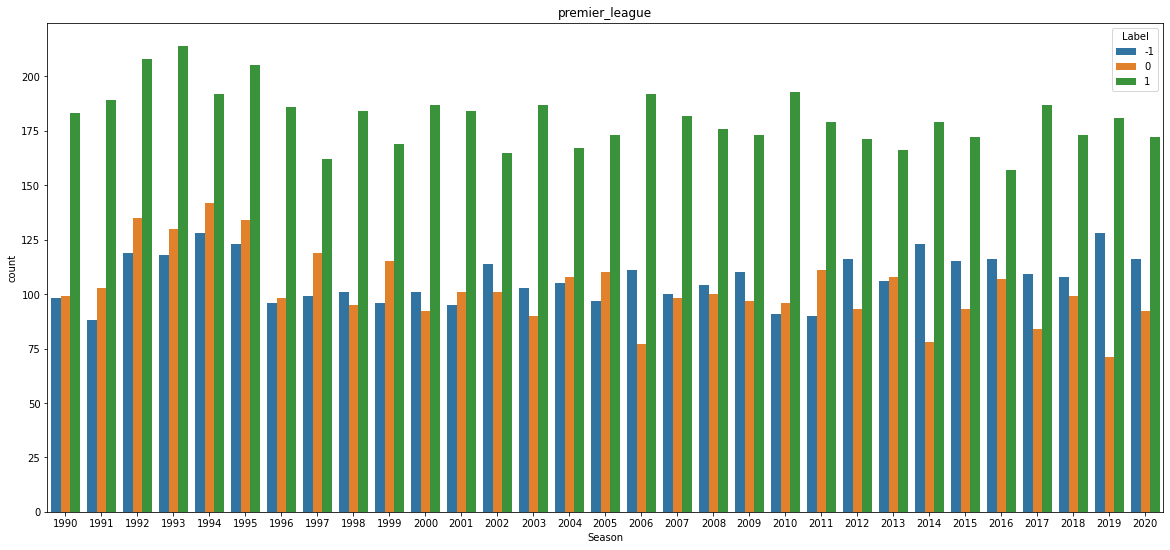

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,9))
plt.title(f"{league}")

sns.countplot(x='Season', data=full_results_table, hue='Label')